In [1]:
import argparse
import json
from typing import List, Optional

from chatrd.core.utils import ChatMessage, MessageRole
from chatrd.engine.components.query_analyzer.conversational import (
    ConversationalPrompter,
)

with open("/home/sagemaker-user/creditcompanion/scripts/conversational_prompting/decision_maker_evaluation_samples.json") as f:
    LOAD_TEST_CASES = json.load(f)

PREPRAED_TEST_CASES = []
for item in LOAD_TEST_CASES:
    test_case = []
    new_history = []
    expected_flag = []
    for message in item["history"]:
        new_history.append(ChatMessage(content=message, role=MessageRole.USER))
    
    PREPRAED_TEST_CASES.append((item["query"], new_history, item["expected_decision_flag"]))

In [2]:
for i in range(5):
    cp = ConversationalPrompter(model_name="haiku", temperature=0.0)
    decision, conversational_prompter_output = cp.run("Can you shorten this response?", [ChatMessage(content="Create a SWOT analysis of (NYSE:IBM) International Business Machines Corporation", role=MessageRole.USER)])
    print(decision, conversational_prompter_output)

flag='rephrasing' initial_question='Can you shorten this response?' rephrased_initial_question='Can you provide a shortened SWOT analysis for International Business Machines Corporation (NYSE:IBM)?' subqueries=['Can you provide a shortened SWOT analysis for International Business Machines Corporation (NYSE:IBM)?']
flag='rephrasing' initial_question='Can you shorten this response?' rephrased_initial_question='Can you provide a shortened SWOT analysis for International Business Machines Corporation (NYSE:IBM)?' subqueries=['Can you provide a shortened SWOT analysis for International Business Machines Corporation (NYSE:IBM)?']
flag='rephrasing' initial_question='Can you shorten this response?' rephrased_initial_question='Can you provide a shortened SWOT analysis for International Business Machines Corporation (NYSE:IBM)?' subqueries=['Can you provide a shortened SWOT analysis for International Business Machines Corporation (NYSE:IBM)?']
flag='rephrasing' initial_question='Can you shorten 

In [3]:
from tqdm import tqdm

test_case_id_list=[]
query_list = []
history_list = []
decision_list = []
conversational_prompter_output_list = []
expected_decision_flag_list = []

cp = ConversationalPrompter(model_name="haiku", temperature=0.0)
for idx, test_case in tqdm(enumerate(PREPRAED_TEST_CASES)):
    query, history, expected_flag = test_case

    for i in range(3):
        decision, conversational_prompter_output = cp.run(query, history)

        test_case_id_list.append(idx)
        query_list.append(query)
        history_list.append(history)
        decision_list.append(decision.flag)
        expected_decision_flag_list.append(expected_flag)
        conversational_prompter_output_list.append(conversational_prompter_output)

0it [00:00, ?it/s]

252it [15:55,  3.79s/it]


In [4]:
import pandas as pd

data = {
    "test_case_id": test_case_id_list,
    "user_query": query_list,
    "chat_history": history_list,
    "predicted_decision_flag": decision_list,
    "expected_decision_flag": expected_decision_flag_list,
    "conversational_prompter_output": conversational_prompter_output_list
}

df = pd.DataFrame(data)

#output_path = "/home/sagemaker-user/creditcompanion/scripts/conversational_prompting/eval.xlsx"
#df.to_excel(output_path, index=True)

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_hat = df.predicted_decision_flag
y_true = df.expected_decision_flag

cm = confusion_matrix(y_true, y_hat, labels=["rephrasing", "clarifying"])

In [6]:
df[df["predicted_decision_flag"] != df["expected_decision_flag"]]

test_case_id                                user_query   
258            86  What are the factors for Bank of Ireland  \

                                          chat_history   
258  [user: What are the scores are modifiers for B...  \

    predicted_decision_flag expected_decision_flag   
258              clarifying             rephrasing  \

                        conversational_prompter_output  
258  clarifying_question='Could you clarify what sp...

In [7]:
filtered_df = df[df["predicted_decision_flag"] != df["expected_decision_flag"]]
# Print each value in the conversational_prompter_output column\
for value in filtered_df["conversational_prompter_output"]:
    print(value)

clarifying_question='Could you clarify what specific factors you would like information about for Bank of Ireland?'


In [8]:
filtered_df = df[df["predicted_decision_flag"] != df["expected_decision_flag"]]
# Print each value in the conversational_prompter_output column\
for value in filtered_df["user_query"]:
    print(value)

What are the factors for Bank of Ireland


Text(0.5, 1.0, 'Confusion Matrix for Decision Maker')

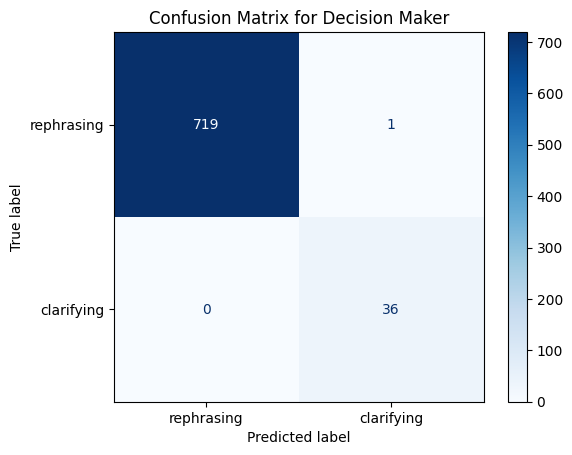

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rephrasing", "clarifying"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Decision Maker")